# KMEANS ON RFM ANALYSIS AND FINDING THE BEST CUSTOMER SEGMENT

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

In [31]:
df=pd.read_csv("Online Retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## REMOVING NULL ROWS OR ROWS HAVING SOME NULL VALUES

In [32]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
(541909, 8)


In [33]:
df=df.dropna()

In [34]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB
None
(406829, 8)


 # RFM stands for:

- Recency (R): How recently a customer made a purchase.
- Frequency (F): How often a customer purchases.
- Monetary (M): How much a customer spends.


# MONETARY 

In [35]:
df['CustomerID'] = df['CustomerID'].astype(str)
df['Amount'] = df['Quantity']*df['UnitPrice']
df_monetary = df.groupby('CustomerID')['Amount'].sum()
df_monetary.reset_index()
df_monetary.columns = ['CustomerID', 'Amount']
print(df_monetary)
print(df_monetary.shape)
print(df_monetary.info())

CustomerID
12346.0       0.00
12347.0    4310.00
12348.0    1797.24
12349.0    1757.55
12350.0     334.40
            ...   
18280.0     180.60
18281.0      80.82
18282.0     176.60
18283.0    2094.88
18287.0    1837.28
Name: Amount, Length: 4372, dtype: float64
(4372,)
<class 'pandas.core.series.Series'>
Index: 4372 entries, 12346.0 to 18287.0
Series name: Amount
Non-Null Count  Dtype  
--------------  -----  
4372 non-null   float64
dtypes: float64(1)
memory usage: 197.4+ KB
None


# FREQUENCY 

In [36]:
df_freq=df.groupby('CustomerID')['InvoiceNo'].count()
df_freq.reset_index()
df_freq.columns=['CustomerID', 'Frequency']
print(df_freq)
print(df_freq.info())

CustomerID
12346.0      2
12347.0    182
12348.0     31
12349.0     73
12350.0     17
          ... 
18280.0     10
18281.0      7
18282.0     13
18283.0    756
18287.0     70
Name: InvoiceNo, Length: 4372, dtype: int64
<class 'pandas.core.series.Series'>
Index: 4372 entries, 12346.0 to 18287.0
Series name: InvoiceNo
Non-Null Count  Dtype
--------------  -----
4372 non-null   int64
dtypes: int64(1)
memory usage: 197.4+ KB
None


# RECENT PURCHASE

In [37]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
max_date=max(df['InvoiceDate'])
df['Diff'] = max_date - df['InvoiceDate']
df_recent = df.groupby('CustomerID')['Diff'].min()
df_recent = df_recent.reset_index()
df_recent.columns =['CustomerID','Diff']
df_recent['Diff']=df_recent['Diff'].dt.days
print(df_recent)

     CustomerID  Diff
0       12346.0   325
1       12347.0     1
2       12348.0    74
3       12349.0    18
4       12350.0   309
...         ...   ...
4367    18280.0   277
4368    18281.0   180
4369    18282.0     7
4370    18283.0     3
4371    18287.0    42

[4372 rows x 2 columns]


# FINAL RFM TABLE

In [38]:
rfm_fin = pd.merge(df_monetary,df_freq,on='CustomerID',how='inner')
rfm_fin = pd.merge(rfm_fin,df_recent,on='CustomerID',how='inner')
rfm_fin.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
print(rfm_fin.head())

  CustomerID   Amount  Frequency  Recency
0    12346.0     0.00          2      325
1    12347.0  4310.00        182        1
2    12348.0  1797.24         31       74
3    12349.0  1757.55         73       18
4    12350.0   334.40         17      309


# OUTLIER REMOVAL ONLY MIDDLE 90% KEPT 

In [39]:
Q1 = rfm_fin.Amount.quantile(0.05)
Q3 = rfm_fin.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm_fin = rfm_fin[(rfm_fin.Amount >= Q1 - 1.5*IQR) & (rfm_fin.Amount <= Q3 + 1.5*IQR)]

Q1 = rfm_fin.Recency.quantile(0.05)
Q3 = rfm_fin.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm_fin = rfm_fin[(rfm_fin.Recency >= Q1 - 1.5*IQR) & (rfm_fin.Recency <= Q3 + 1.5*IQR)]

Q1 = rfm_fin.Frequency.quantile(0.05)
Q3 = rfm_fin.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm_fin = rfm_fin[(rfm_fin.Frequency >= Q1 - 1.5*IQR) & (rfm_fin.Frequency <= Q3 + 1.5*IQR)]

In [40]:
print(rfm_fin.shape)

(4293, 4)


## DATA SCALING

In [41]:
#scaling
X =rfm_fin[['Amount', 'Frequency', 'Recency']]
scaler= MinMaxScaler()
rfm_fin_scaled = scaler.fit_transform(X)

In [43]:
rfm_fin_scaled= pd.DataFrame(rfm_fin_scaled)#OUTPUT WAS NUMPY ARRAY
rfm_fin_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_fin_scaled.head()

,Amount,Frequency,Recency
0,0.238663,0.001395,0.871314
1,0.478571,0.252441,0.002681
2,0.338703,0.041841,0.198391
3,0.336494,0.100418,0.048257
4,0.257277,0.022315,0.828418


## model creation

In [44]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_fin_scaled)
labels=kmeans.labels_
print(kmeans.labels_)

[1 0 2 ... 1 2 2]


# FINDING OPTIMAL CLUSTER VALUE

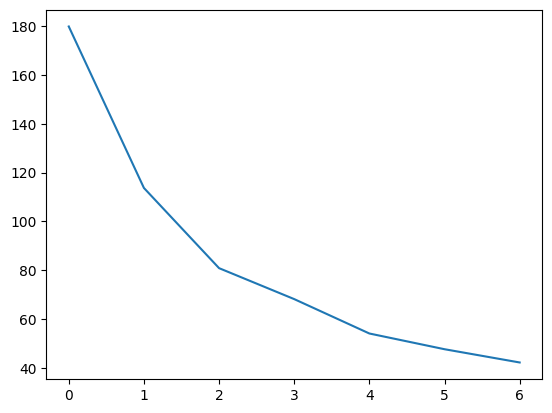

In [45]:
#wss
wss = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_fin_scaled)
    wss.append(kmeans.inertia_)
plt.plot(wss)

# Silhouette Analysis
- silhouette score=𝑝−𝑞/𝑚𝑎𝑥(𝑝,𝑞)
- 𝑝 is the mean distance to the points in the nearest cluster that the data point is not a part of
- 𝑞 is the mean intra-cluster distance to all the points in its own cluster.
- The value of the silhouette score range lies between -1 to 1.
- A score closer to 1 indicates that the data point is very similar to other data points in the cluster,
- A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [46]:
#silhouette score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_fin_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_fin_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5889064222823147
For n_clusters=3, the silhouette score is 0.5463696743794696
For n_clusters=4, the silhouette score is 0.5009429639714229
For n_clusters=5, the silhouette score is 0.383466776770701
For n_clusters=6, the silhouette score is 0.40399871331602016
For n_clusters=7, the silhouette score is 0.39467458183005577
For n_clusters=8, the silhouette score is 0.3797356734610847


# RFM FINAL TABLE WITH CLUSTER LABELS

In [47]:
rfm_fin['Cluster_Id'] = labels
rfm_fin.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,1


<Axes: xlabel='Cluster_Id', ylabel='Amount'>

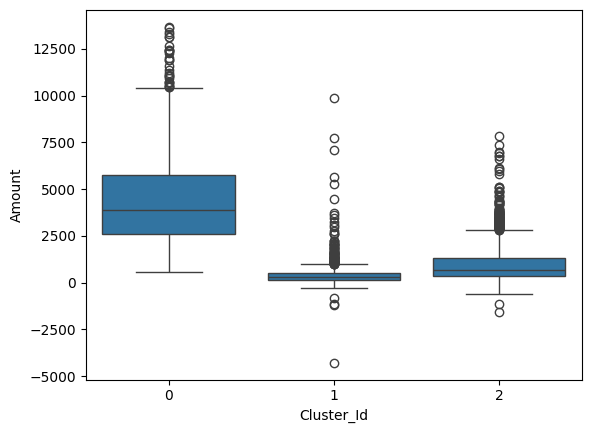

In [48]:
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm_fin)

<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

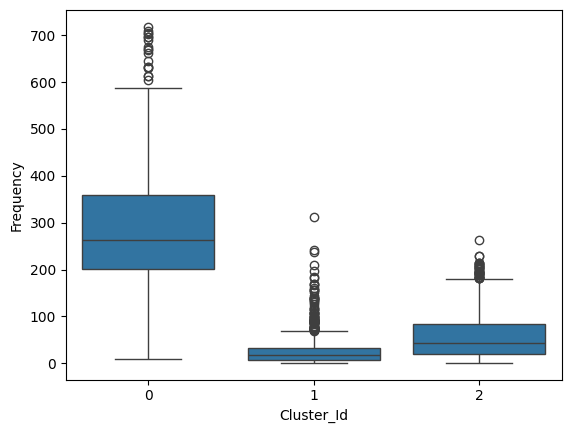

In [49]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm_fin)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

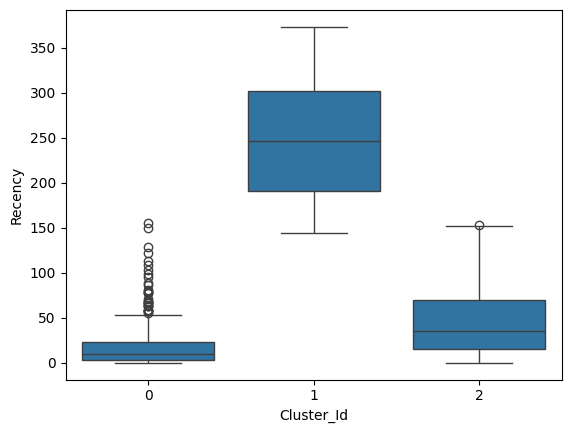

In [50]:
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm_fin)

## CLEARLY ABOVE CLUSTER 0 HAD BEST DATA FOR THE COMPANY WITH HIGH MONETARY AND HIGH FREQUENCY 

In [54]:
cluster_summary = rfm_fin.groupby('Cluster_Id').agg({
    'Amount': 'mean',
    'Frequency': 'mean',
    'Recency': 'mean'
}).reset_index()

print(cluster_summary)


   Cluster_Id       Amount   Frequency     Recency
0           0  4569.145392  293.296078   17.527451
1           1   440.080750   27.327324  250.233397
2           2   974.630690   56.523635   45.667277


In [56]:
best_cluster_id = cluster_summary.sort_values(by=['Amount', 'Frequency'], ascending=[False, False]).iloc[0]['Cluster_Id']
best_customers = rfm_fin[rfm_fin['Cluster_Id'] == best_cluster_id]
print(best_customers)


     CustomerID   Amount  Frequency  Recency  Cluster_Id
1       12347.0  4310.00        182        1           0
10      12357.0  6207.67        131       32           0
12      12359.0  6245.53        254        7           0
15      12362.0  5154.58        274        2           0
20      12370.0  3545.69        167       50           0
...         ...      ...        ...      ...         ...
4326    18225.0  5361.02        286        2           0
4327    18226.0  5192.10        245       38           0
4330    18229.0  7276.90        164       11           0
4342    18245.0  2507.56        177        6           0
4361    18272.0  3064.78        170        2           0

[510 rows x 5 columns]


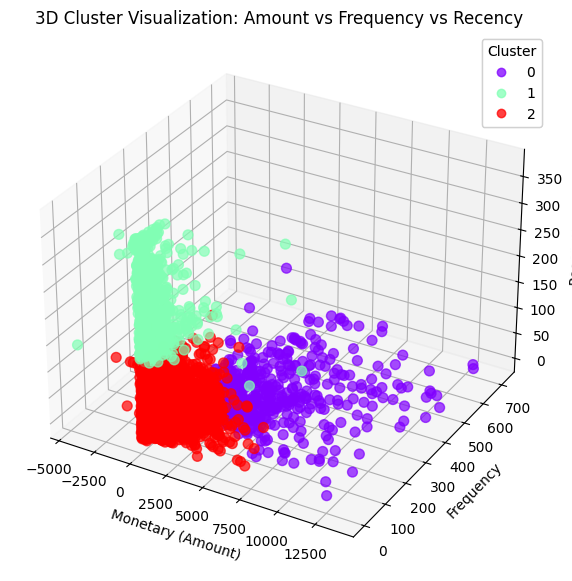

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    rfm_fin['Amount'], 
    rfm_fin['Frequency'], 
    rfm_fin['Recency'], 
    c=rfm_fin['Cluster_Id'],
    cmap='rainbow', 
    s=50, 
    alpha=0.7
)
# Labels
ax.set_xlabel("Monetary (Amount)")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
ax.set_title("3D Cluster Visualization: Amount vs Frequency vs Recency")

legend = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend)

plt.show()
